--- Análise da Estratégia Financeira (Valores por Pacote Unitário) ---
Premissa de Câmbio Inicial (S0): BRL/USD 5.40
Strike da Call (K): BRL/USD 5.80

Prémio Recebido pela Venda da Call: BRL 0.1263
Investimento no Título: BRL 89.95
Investimento em USD: BRL 5.40
----------------------------------------
Investimento Total Bruto: BRL 95.35
Fluxo de Caixa Inicial Líquido: BRL -95.22

Lucro Máximo por Pacote (se BRL/USD >= 5.80): BRL 10.58
Lucro Máximo Total (100.000 pacotes): BRL 1.057.633.18


--- Tabela de Sensibilidades da Estratégia (Gregas) ---
                   Delta   Gamma    Vega   Volga  Rho (BRL)  Rho (USD)  Theta (p/dia)
Long 1 USD        1.0000  0.0000  0.0000  0.0000     0.0000     0.0000         0.0000
Título Corp.      0.0000  0.0000  0.0000  0.0000     0.0000     0.0000         0.0000
Short Call       -0.3453 -0.6328 -0.0138 -0.0165    -0.0087     0.0093         0.0003
Total Estratégia  0.6547 -0.6328 -0.0138 -0.0165    -0.0087     0.0093         0.0003

AVISO: Os cálculo

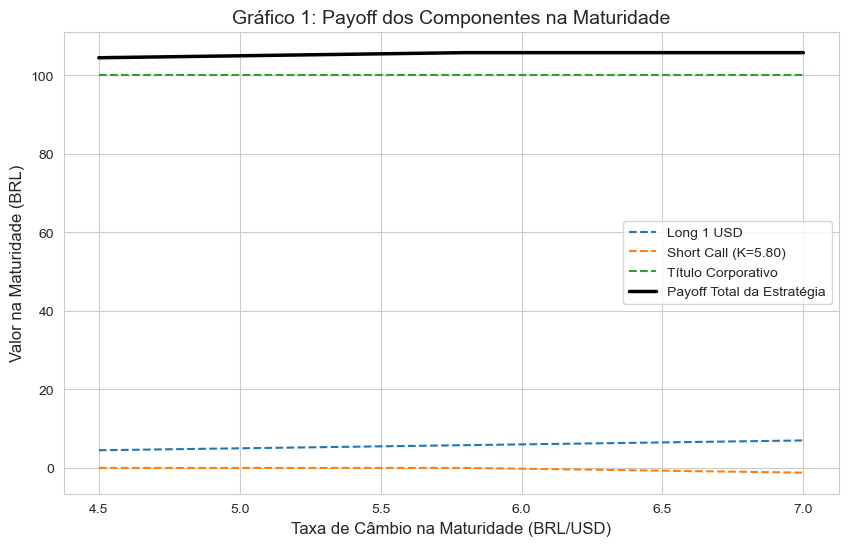

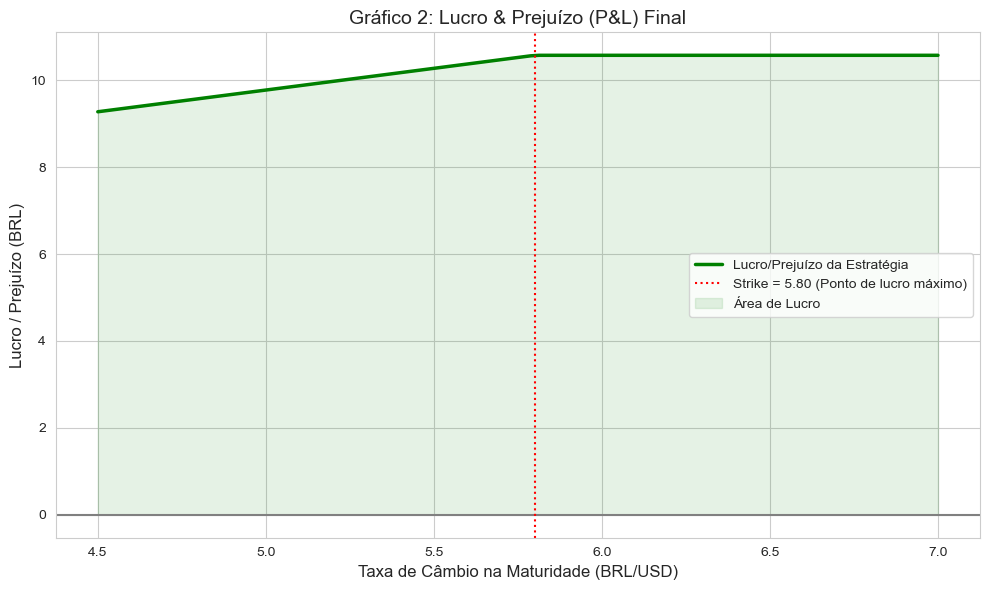

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import pandas as pd

# --- Parâmetros e Premissas ---
S0 = 5.40      # Taxa de câmbio BRL/USD atual (premissa)
K = 5.80       # Preço de exercício (Strike) da call
T = 0.5        # Maturidade em anos (6 meses)
r_brl = 0.105  # Taxa de juros livre de risco no Brasil (SELIC, premissa)
r_usd = 0.0525 # Taxa de juros livre de risco nos EUA (Fed Funds, premissa)
sigma = 0.15   # Volatilidade implícita do par BRL/USD (premissa)
bond_notional = 100.00 # Valor de face do título em BRL
bond_price = 89.95     # Preço de compra (investimento inicial) do título em BRL

# Estratégia
num_packages = 100000  # Quantidade de pacotes unitários

# --- Funções de Precificação e Gregas (Garman-Kohlhagen) ---

def calculate_d1_d2(S, K, T, r_d, r_f, sigma):
    """Calcula os parâmetros d1 e d2."""
    d1 = (np.log(S / K) + (r_d - r_f + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return d1, d2

def garman_kohlhagen_call(S, K, T, r_d, r_f, sigma):
    """Calcula o prémio de uma call de câmbio."""
    d1, d2 = calculate_d1_d2(S, K, T, r_d, r_f, sigma)
    call_price = S * np.exp(-r_f * T) * norm.cdf(d1) - K * np.exp(-r_d * T) * norm.cdf(d2)
    return call_price

def delta_call(S, K, T, r_d, r_f, sigma):
    """Calcula o Delta de uma call de câmbio."""
    d1, _ = calculate_d1_d2(S, K, T, r_d, r_f, sigma)
    return np.exp(-r_f * T) * norm.cdf(d1)

def gamma(S, K, T, r_d, r_f, sigma):
    """Calcula o Gamma de uma call de câmbio."""
    d1, _ = calculate_d1_d2(S, K, T, r_d, r_f, sigma)
    return (norm.pdf(d1) * np.exp(-r_f * T)) / (S * sigma * np.sqrt(T))

def vega(S, K, T, r_d, r_f, sigma):
    """Calcula o Vega de uma call de câmbio."""
    d1, _ = calculate_d1_d2(S, K, T, r_d, r_f, sigma)
    return S * np.exp(-r_f * T) * norm.pdf(d1) * np.sqrt(T)

def volga(S, K, T, r_d, r_f, sigma):
    """Calcula o Volga (Vomma) de uma call de câmbio."""
    d1, d2 = calculate_d1_d2(S, K, T, r_d, r_f, sigma)
    return vega(S, K, T, r_d, r_f, sigma) * ((d1 * d2) / sigma)

def rho_d_call(S, K, T, r_d, r_f, sigma):
    """Calcula o Rho para a taxa de juro doméstica (r_d)."""
    _, d2 = calculate_d1_d2(S, K, T, r_d, r_f, sigma)
    return K * T * np.exp(-r_d * T) * norm.cdf(d2)

def rho_f_call(S, K, T, r_d, r_f, sigma):
    """Calcula o Rho para a taxa de juro estrangeira (r_f)."""
    d1, _ = calculate_d1_d2(S, K, T, r_d, r_f, sigma)
    return -S * T * np.exp(-r_f * T) * norm.cdf(d1)

def theta_call(S, K, T, r_d, r_f, sigma):
    """Calcula o Theta de uma call de câmbio (por ano)."""
    d1, d2 = calculate_d1_d2(S, K, T, r_d, r_f, sigma)
    term1 = -(S * np.exp(-r_f * T) * norm.pdf(d1) * sigma) / (2 * np.sqrt(T))
    term2 = -S * r_f * np.exp(-r_f * T) * norm.cdf(d1)
    term3 = K * r_d * np.exp(-r_d * T) * norm.cdf(d2)
    return term1 + term2 + term3


# --- Cálculos da Estratégia Unitária ---

# 1. Calcular o prémio recebido pela venda da call
call_premium = garman_kohlhagen_call(S0, K, T, r_brl, r_usd, sigma)

# 2. Calcular o investimento inicial líquido por pacote
initial_investment_usd = S0
initial_investment_bond = bond_price
total_initial_investment = initial_investment_usd + initial_investment_bond
net_initial_cashflow = call_premium - total_initial_investment

# 3. Criar um intervalo de possíveis taxas de câmbio na maturidade (ST)
ST_range = np.linspace(4.5, 7.0, 100)

# 4. Calcular os payoffs na maturidade
payoff_long_usd = ST_range
payoff_short_call = -np.maximum(ST_range - K, 0)
payoff_bond = np.full_like(ST_range, bond_notional)
payoff_total = payoff_long_usd + payoff_short_call + payoff_bond

# 5. Calcular o Lucro/Prejuízo (P&L) final
pnl_total = payoff_total - total_initial_investment + call_premium


# --- Análise de Sensibilidades (Gregas) ---

# Gregas para cada componente
greeks = {
    'Long 1 USD': {'Delta': 1.0, 'Gamma': 0.0, 'Vega': 0.0, 'Volga': 0.0, 'Rho (BRL)': 0.0, 'Rho (USD)': 0.0, 'Theta (p/dia)': 0.0},
    'Título Corp.': {'Delta': 0.0, 'Gamma': 0.0, 'Vega': 0.0, 'Volga': 0.0, 'Rho (BRL)': 0.0, 'Rho (USD)': 0.0, 'Theta (p/dia)': 0.0},
    'Short Call': {
        'Delta': -delta_call(S0, K, T, r_brl, r_usd, sigma),
        'Gamma': -gamma(S0, K, T, r_brl, r_usd, sigma),
        'Vega': -vega(S0, K, T, r_brl, r_usd, sigma) / 100, # Vega por 1% de mudança na vol
        'Volga': -volga(S0, K, T, r_brl, r_usd, sigma) / 100,
        'Rho (BRL)': -rho_d_call(S0, K, T, r_brl, r_usd, sigma) / 100, # Rho por 1% de mudança na taxa
        'Rho (USD)': -rho_f_call(S0, K, T, r_brl, r_usd, sigma) / 100, # Rho por 1% de mudança na taxa
        'Theta (p/dia)': -theta_call(S0, K, T, r_brl, r_usd, sigma) / 365 # Theta anualizado para diário
    }
}

# DataFrame para exibir as gregas
df_greeks = pd.DataFrame(greeks).T
df_greeks.loc['Total Estratégia'] = df_greeks.sum()


# --- Exibindo Resultados ---

print("--- Análise da Estratégia Financeira (Valores por Pacote Unitário) ---")
print(f"Premissa de Câmbio Inicial (S0): BRL/USD {S0:.2f}")
print(f"Strike da Call (K): BRL/USD {K:.2f}\n")
print(f"Prémio Recebido pela Venda da Call: BRL {call_premium:.4f}")
print(f"Investimento no Título: BRL {initial_investment_bond:.2f}")
print(f"Investimento em USD: BRL {initial_investment_usd:.2f}")
print("-" * 40)
print(f"Investimento Total Bruto: BRL {total_initial_investment:.2f}")
print(f"Fluxo de Caixa Inicial Líquido: BRL {net_initial_cashflow:.2f}\n")

# Ponto de lucro máximo (quando ST >= K)
max_profit = pnl_total[ST_range >= K][0]
print(f"Lucro Máximo por Pacote (se BRL/USD >= {K:.2f}): BRL {max_profit:.2f}")
print(f"Lucro Máximo Total ({num_packages:,} pacotes): BRL {max_profit * num_packages:,.2f}\n".replace(',', '.'))

print("\n--- Tabela de Sensibilidades da Estratégia (Gregas) ---")
print(df_greeks.to_string(float_format="%.4f"))
print("\nAVISO: Os cálculos acima assumem que o título corporativo NÃO sofra default.")


# --- Configuração e Geração dos Gráficos ---
sns.set_style("whitegrid")

# Gráfico 1: Payoff dos Componentes na Maturidade
plt.figure(figsize=(10, 6))
plt.plot(ST_range, payoff_long_usd, label='Long 1 USD', linestyle='--')
plt.plot(ST_range, payoff_short_call, label=f'Short Call (K={K:.2f})', linestyle='--')
plt.plot(ST_range, payoff_bond, label='Título Corporativo', linestyle='--')
plt.plot(ST_range, payoff_total, label='Payoff Total da Estratégia', color='black', linewidth=2.5)
plt.title('Gráfico 1: Payoff dos Componentes na Maturidade', fontsize=14)
plt.xlabel('Taxa de Câmbio na Maturidade (BRL/USD)', fontsize=12)
plt.ylabel('Valor na Maturidade (BRL)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# Gráfico 2: Lucro & Prejuízo (P&L) da Estratégia
plt.figure(figsize=(10, 6))
plt.plot(ST_range, pnl_total, label='Lucro/Prejuízo da Estratégia', color='green', linewidth=2.5)
plt.axhline(0, color='grey', linestyle='-')
plt.axvline(K, color='red', linestyle=':', label=f'Strike = {K:.2f} (Ponto de lucro máximo)')
plt.fill_between(ST_range, pnl_total, where=(pnl_total > 0), color='green', alpha=0.1, label='Área de Lucro')
plt.title('Gráfico 2: Lucro & Prejuízo (P&L) Final', fontsize=14)
plt.xlabel('Taxa de Câmbio na Maturidade (BRL/USD)', fontsize=12)
plt.ylabel('Lucro / Prejuízo (BRL)', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Baixando dados de BRL=X para os últimos 10y...


[*********************100%***********************]  1 of 1 completed


Total de 2603 observações de retornos diários.
24 outliers removidos (fora de 3.0 desvios-padrão).
Total de 2579 observações após a limpeza.

--- Momentos dos Retornos Diários ---
Média: 0.000091
Desvio Padrão (Volatilidade): 0.009519
Assimetria (Skewness): 0.0394
Curtose (Kurtosis): 0.5911

--- Métricas de Risco: Value at Risk (VaR) e Expected Shortfall (ES) ---
  Confiança  Horizonte (dias)  VaR Paramétrico  ES Paramétrico  VaR Histórico  ES Histórico
0       95%                 1          -0.0156         -0.0195        -0.0157       -0.0208
1       95%                 5          -0.0346         -0.0435        -0.0352       -0.0465
2       99%                 1          -0.0221         -0.0253        -0.0245       -0.0270
3       99%                 5          -0.0491         -0.0563        -0.0547       -0.0605


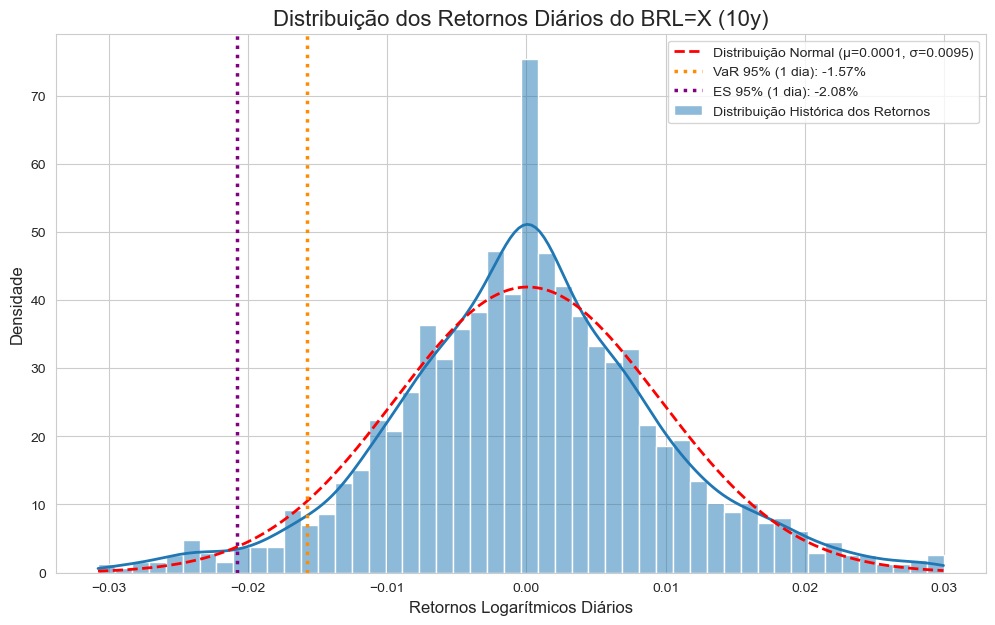

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, skew, kurtosis

# --- Parâmetros ---
TICKER = 'BRL=X'
PERIODO = '10y'
CONFIDENCE_LEVELS = [0.95, 0.99]
OUTLIER_STD_DEV = 3.0

# --- Funções de Cálculo de Risco ---

def calculate_parametric_var(mean, std, confidence_level, dist=norm):
    """Calcula o VaR Paramétrico para uma dada distribuição."""
    return mean + std * dist.ppf(1 - confidence_level)

def calculate_parametric_es(mean, std, confidence_level, dist=norm):
    """Calcula o ES Paramétrico para uma dada distribuição (assumindo normalidade)."""
    if dist.name != 'norm':
        print("Cálculo de ES paramétrico implementado apenas para distribuição Normal.")
        return np.nan
    alpha = 1 - confidence_level
    return mean - std * (dist.pdf(dist.ppf(alpha)) / alpha)

def calculate_historical_var(returns, confidence_level):
    """Calcula o VaR Histórico."""
    return returns.quantile(1 - confidence_level)

def calculate_historical_es(returns, confidence_level):
    """Calcula o ES Histórico."""
    var = calculate_historical_var(returns, confidence_level)
    return returns[returns <= var].mean()


# --- Download e Preparação dos Dados ---
print(f"Baixando dados de {TICKER} para os últimos {PERIODO}...")
data = yf.download(TICKER, period=PERIODO, auto_adjust=True)

# Calcula os retornos logarítmicos diários
data['returns'] = np.log(data['Close'] / data['Close'].shift(1))
data.dropna(inplace=True)

print(f"Total de {len(data)} observações de retornos diários.")

# --- Remoção de Outliers ---
mean_ret = data['returns'].mean()
std_ret = data['returns'].std()
upper_bound = mean_ret + OUTLIER_STD_DEV * std_ret
lower_bound = mean_ret - OUTLIER_STD_DEV * std_ret

original_count = len(data)
# Filtra os retornos
returns_filtered = data['returns'][
    (data['returns'] >= lower_bound) & (data['returns'] <= upper_bound)
].copy()

print(f"{original_count - len(returns_filtered)} outliers removidos (fora de {OUTLIER_STD_DEV} desvios-padrão).")
print(f"Total de {len(returns_filtered)} observações após a limpeza.")

# --- Cálculo dos Momentos da Distribuição ---
mean_final = returns_filtered.mean()
std_final = returns_filtered.std()
skewness = skew(returns_filtered)
kurt = kurtosis(returns_filtered) # Kurtosis em excesso

print("\n--- Momentos dos Retornos Diários ---")
print(f"Média: {mean_final:.6f}")
print(f"Desvio Padrão (Volatilidade): {std_final:.6f}")
print(f"Assimetria (Skewness): {skewness:.4f}")
print(f"Curtose (Kurtosis): {kurt:.4f}")

# --- Cálculo do VaR e ES ---
results = []
horizons = [1, 5] # Dias

for cl in CONFIDENCE_LEVELS:
    for h in horizons:
        # Ajusta os momentos para o horizonte de tempo
        h_mean = mean_final * h
        h_std = std_final * np.sqrt(h)
        h_returns = returns_filtered * np.sqrt(h) # Simplificação para o método histórico

        # Cálculos
        p_var = calculate_parametric_var(h_mean, h_std, cl)
        p_es = calculate_parametric_es(h_mean, h_std, cl)
        h_var = calculate_historical_var(returns_filtered, cl) * np.sqrt(h)
        h_es = calculate_historical_es(returns_filtered, cl) * np.sqrt(h)

        results.append({
            'Confiança': f"{cl:.0%}",
            'Horizonte (dias)': h,
            'VaR Paramétrico': p_var,
            'ES Paramétrico': p_es,
            'VaR Histórico': h_var,
            'ES Histórico': h_es,
        })

df_risk = pd.DataFrame(results)
print("\n--- Métricas de Risco: Value at Risk (VaR) e Expected Shortfall (ES) ---")
print(df_risk.to_string(float_format="%.4f"))


# --- Gráfico ---
sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))

# Histograma dos retornos
sns.histplot(returns_filtered, bins=50, kde=True, stat='density',
             label='Distribuição Histórica dos Retornos',
             line_kws={'linewidth': 2})

# Curva da distribuição normal para comparação
x_range = np.linspace(returns_filtered.min(), returns_filtered.max(), 1000)
plt.plot(x_range, norm.pdf(x_range, mean_final, std_final), 'r--',
         label=f'Distribuição Normal (μ={mean_final:.4f}, σ={std_final:.4f})',
         linewidth=2)

# Linhas de VaR e ES (para 1 dia e 95% de confiança)
var_95_1d = df_risk[(df_risk['Confiança'] == '95%') & (df_risk['Horizonte (dias)'] == 1)]['VaR Histórico'].values[0]
es_95_1d = df_risk[(df_risk['Confiança'] == '95%') & (df_risk['Horizonte (dias)'] == 1)]['ES Histórico'].values[0]

plt.axvline(var_95_1d, color='darkorange', linestyle=':', linewidth=2.5,
            label=f'VaR 95% (1 dia): {var_95_1d:.2%}')
plt.axvline(es_95_1d, color='purple', linestyle=':', linewidth=2.5,
            label=f'ES 95% (1 dia): {es_95_1d:.2%}')


plt.title(f'Distribuição dos Retornos Diários do {TICKER} ({PERIODO})', fontsize=16)
plt.xlabel('Retornos Logarítmicos Diários', fontsize=12)
plt.ylabel('Densidade', fontsize=12)
plt.legend()
plt.show()